# Тема: "Изучение поведения пользователей мобильного приложения стартапа, продающего продукты питания"

Краткое описание.

Стартапу, продающему через мобильное приложение продукты питания, необходимо провести анализ поведения пользователей в мобильном приложении. Изучить воронку продаж. Отследить переходы на следующие этапы пользовательского пути. После проведения А/А/В теста необходимо принять решение о смене шрифтов в мобильном приложении.

Цель проекта: изучение поведения пользователей, воронки продаж, проведение А/А/Б тестирования, анализ результатов

Задачи проекта:

    Изучение поведения пользователей.
    Изучение воронки продаж.
    Проведение А/А/Б тестирования.
    Анализ результатов.

План (декомпозиция) проекта:

    Изучение предоставленного датасета.
    Подготовка данных, проверка пропусков, типов данных.
    Подсчет событий в логе.
    Подсчет пользователей в логе.
    Подсчет среднего количества событий на пользователя.
    Анализ временного периода предоставленных данных.
    Отброс неподходящих данных по времени.
    Изучение воронки событий.
    Анализ видов событий и их частоты.
    Подсчет пользователей, совершивших события.
    Анализ порядка событий.
    Подсчет доли пользователей, проходящих на следующий шаг воронки.
    Подсчет потери пользователей.
    Подсчет доли пользователей, проходящих до оплаты.
    Изучение результата эксперимента.
    Подсчет пользователей в каждой экспериментальной группе.
    Подсчет статистических критериев разницы между выборками.
    Написание выводов.
    

### Изучение предоставленного датасета.

In [1]:
import os
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import math as mth
import seaborn 
from pandas.plotting import register_matplotlib_converters
import scipy.stats as stats
from plotly import graph_objects as go
from statsmodels. stats.weightstats import ztest as ztest
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters() 
import warnings 
warnings.filterwarnings ('ignore')

Изучим датафрейм

In [2]:
pth1 = "C:\datasets\logs_exp.csv"

if os.path.exists(pth1):
    df = pd.read_csv(pth1, sep='\t')
else:
    print('Something is wrong')

Структура данных logs_exp:

  1.  EventName — название события.
  2.  DeviceIDHash — уникальный идентификатор пользователя.
  3.  EventTimestamp — время события.
  4.  ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [3]:
df.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Датасет содержит 244126 не нулевых значений. Пропусков нет. Есть несоответствия формата некоторых данных их содержанию. 

### Подготовка данных.

Изменим названия колонок на более удобные.

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
df.columns=['event', 'user', 'timestamp', 'group']

In [7]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      244126 non-null  object
 1   user       244126 non-null  int64 
 2   timestamp  244126 non-null  int64 
 3   group      244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [8]:
df.head(10)

,event,user,timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


Изменим не соответствующие типы данных.

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

Проверим изменения.

In [10]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      244126 non-null  object        
 1   user       244126 non-null  int64         
 2   timestamp  244126 non-null  datetime64[ns]
 3   group      244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


Проверим датасет на дубликаты.

In [11]:
df.duplicated().sum()

413

В датасете присутствует 413 дубликатов. С ними нужно будет поработать дальше по тексту проекта, посмотреть и принять решение об удалении.

Проверим данные датафрейма на пропуски.

In [12]:
df.isna().sum()

event        0
user         0
timestamp    0
group        0
dtype: int64

Пропусков нет.

In [13]:
df[df.duplicated()==True].sort_values(by=['user','timestamp','event','group']).head(30)

,event,user,timestamp,group
130558,MainScreenAppear,33176906322804559,2019-08-04 15:37:55,248
130995,OffersScreenAppear,33176906322804559,2019-08-04 15:49:23,248
104108,CartScreenAppear,34565258828294726,2019-08-03 18:33:41,248
159302,PaymentScreenSuccessful,54903596035630984,2019-08-05 13:27:52,248
176813,PaymentScreenSuccessful,77364241990273403,2019-08-05 22:38:52,246
189896,MainScreenAppear,91292479590032512,2019-08-06 10:35:23,246
155464,MainScreenAppear,95206628315371849,2019-08-05 11:48:44,247
110479,MainScreenAppear,170935625628929269,2019-08-04 05:44:47,246
17037,CartScreenAppear,197027893265565660,2019-08-01 11:40:14,246
23421,CartScreenAppear,197027893265565660,2019-08-01 14:15:28,246


При визуальном осмотре кусочка данных дубликатов можно даже заметить их повторяемость. Например данные юзера 636437379427729086

In [14]:
df[(df['user']==636437379427729086) & (df['timestamp']=='2019-08-02 06:10:05')]

,event,user,timestamp,group
44071,PaymentScreenSuccessful,636437379427729086,2019-08-02 06:10:05,247
44073,PaymentScreenSuccessful,636437379427729086,2019-08-02 06:10:05,247
44074,PaymentScreenSuccessful,636437379427729086,2019-08-02 06:10:05,247
44075,PaymentScreenSuccessful,636437379427729086,2019-08-02 06:10:05,247


Относительные потери дубликатов можно посчитать: всего данных 244126 строк, дубликатов 413. Это 0.17 % от имеющихся данных. Удалим дубликаты.


In [15]:
df = df.drop_duplicates()
print('Кол-во оставшихся дубликатов =', df.duplicated().sum())

Кол-во оставшихся дубликатов = 0


In [16]:
df = df.reset_index(drop=True)

Добавим столбец даты и времени, а также отдельный столбец дат.

In [17]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.head(5)

,event,user,timestamp,group,datetime
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25 11:48:42


In [18]:
df['date'] = df['datetime'].dt.date.astype('datetime64')
df.head(5)

,event,user,timestamp,group,datetime,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25 11:48:42,2019-07-25


Проверим типы данных.


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   user       243713 non-null  int64         
 2   timestamp  243713 non-null  datetime64[ns]
 3   group      243713 non-null  int64         
 4   datetime   243713 non-null  datetime64[ns]
 5   date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 11.2+ MB


Проверим данные колонки group на уникальные значения и на пересечение значений.


In [20]:
df['group'].unique()

array([246, 248, 247], dtype=int64)

In [21]:
# отбираем группы из данных 
group_246 =df.query('group == "246"') 
group_247=df.query('group == "247"') 


# получаем id пользователей, попавших в обе группы 
group_int=list(np.intersect1d(group_246['user'], group_247['user']))
len(group_int)

0

In [22]:
# отбираем группы из данных 
group_248=df.query('group == "248"')
group_247=df.query('group == "247"') 


# получаем id пользователей, попавших в обе группы 
group_int=list(np.intersect1d(group_248['user'], group_247['user']))
len(group_int)

0

In [23]:
group_246 =df.query('group == "246"') 
group_248=df.query('group == "248"')

# получаем id пользователей, попавших в обе группы 
group_int=list(np.intersect1d(group_248['user'], group_246['user']))
len(group_int)

0

Данные групп 246, 247 и 248 не пересекаются.

Посмотрим на размеры групп.

In [24]:
d=df.groupby('group').agg({'user': 'nunique'})
d

,user
group,
246,2489
247,2520
248,2542


Посмотрим на процентное соотношение размеров групп.


In [25]:
d['%']= round((d/df['user'].nunique()*100),2)
d

,user,%
group,,
246,2489,32.96
247,2520,33.37
248,2542,33.66


Размеры групп почти не отличаются друг от друга и находятся в пределах 33%. Статистические критерии разницы между выборками будут рассмотрены ниже.


Подготовка данных завершена. Созданы необходимые дополнительные столбцы, изменены, там где необходимо, типы данных, удалены дубликаты. Относительные потери от удаления дубликатов составили 0.17% от общего количества данных. Данные в колонке group по исследуемым группам 246, 247 и 248 не пересекаются между собой. У нас три группы в исследовании, значит тест множественный. Группы примерно равны по размеру. Очень незначительно отличаются друг от друга. Статистические критерии разницы будут рассмотрены ниже. Можно приступать к дальнейшим этапам исследования.

### Изучение и проверка данных.

Подсчет количества событий в логе.

In [26]:
df['event'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

In [27]:
df['event'].nunique()

5

In [28]:
df['event'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Количество уникальных событий в логе равно 5:
1. Мainscreenappear - просмотр главного экрана.
2. OffersScreenAppear - просмотр предложений на экране.
3. CartScreenAppear - просмотр экрана корзины.
4. PaymentScreenSuccessful - просмотр экранов оплаты картой.
5. Tutorial - просмотр обучающей части.

Подсчет количества пользователей в логе.

In [29]:
users = df['user'].nunique()
print('Уникальных пользователей в таблице =', users)

Уникальных пользователей в таблице = 7551


 Подсчет среднего количества событий на пользователя


In [30]:
all_events = df['event'].count()
print('Общее количество событий =', all_events)

Общее количество событий = 243713


In [31]:
print("Среднее количество событий на пользователя =", (all_events / users).round(2))

Среднее количество событий на пользователя = 32.28


Среднее арифметическое значение количества событий на пользователя равно 32.28, но посмотрим на другие значения. Вдруг есть выбросы, которые влияют на среднее количество и нам нужно будет взять медиану.


In [32]:
event_per_user = df.groupby('user')['event'].count()
event_per_user.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event, dtype: float64

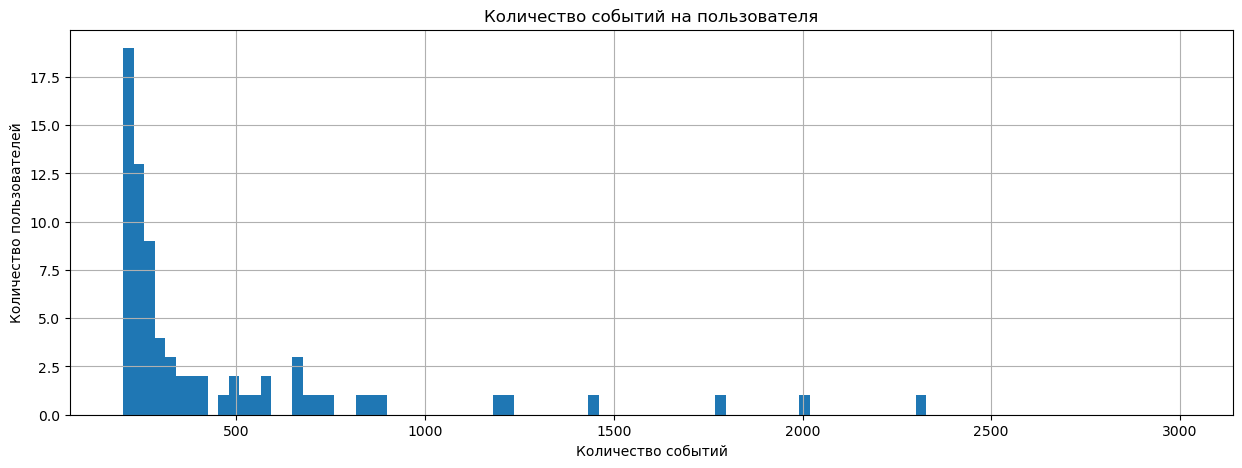

In [33]:
plt.figure(figsize=(15,5))
plt.hist(event_per_user, bins=100, range=(200,3000)) 
plt.xlabel('Количество событий')
plt.grid()
plt.ylabel('Количество пользователей')
plt.title('Количество событий на пользователя');

Максимальное значение количества событий на пользователя равно 2307, а минимальное количество событий на пользователя равно 1, соответственно, разброс значений очень большой и на графике видны редкие выбросы, которые искажают данные в основном сгруппированные в значении до 500, значит необходимо остановиться на медианном значении в 20 событий на пользователя.

Анализ временного периода предоставленных данных.

In [34]:
print(f"Период данных в датасете: с {df['datetime'].min()} по {df['datetime'].max()}")
print(f"Размер периода: {df['datetime'].max() - df['datetime'].min()}")

Период данных в датасете: с 2019-07-25 04:43:36 по 2019-08-07 21:15:17
Размер периода: 13 days 16:31:41


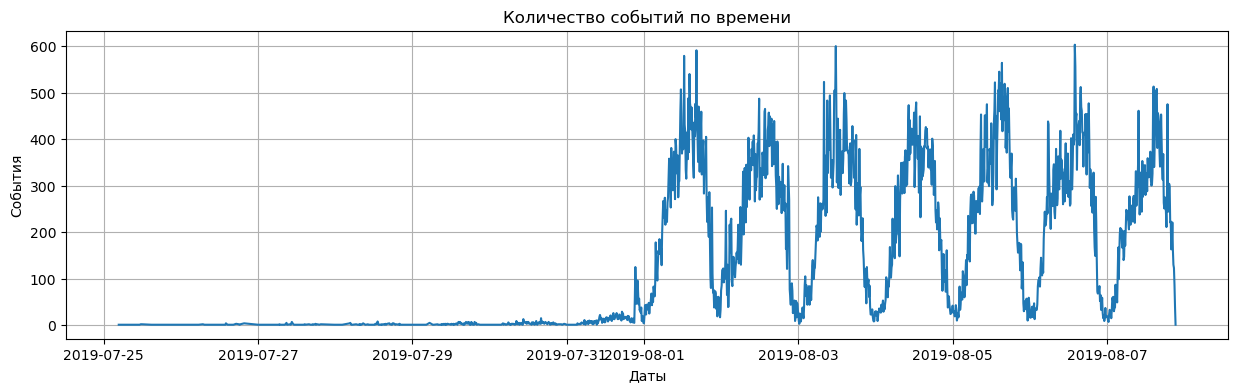

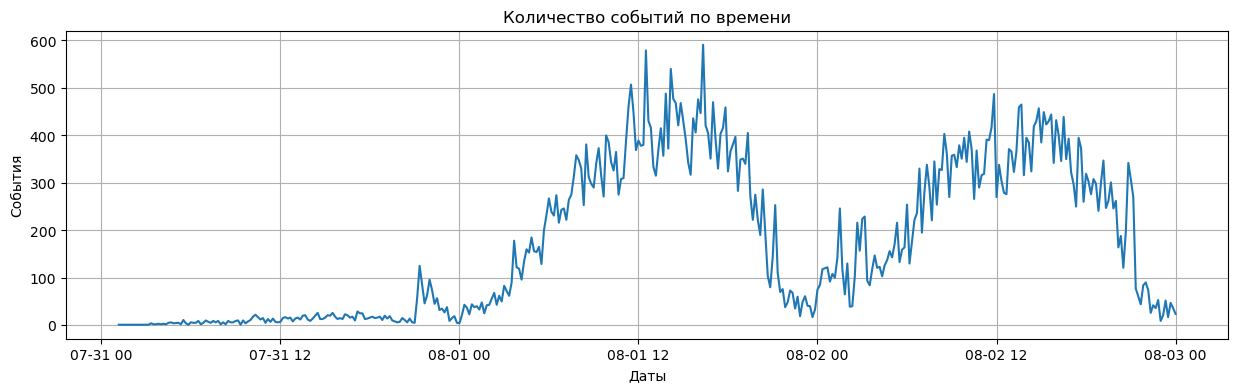

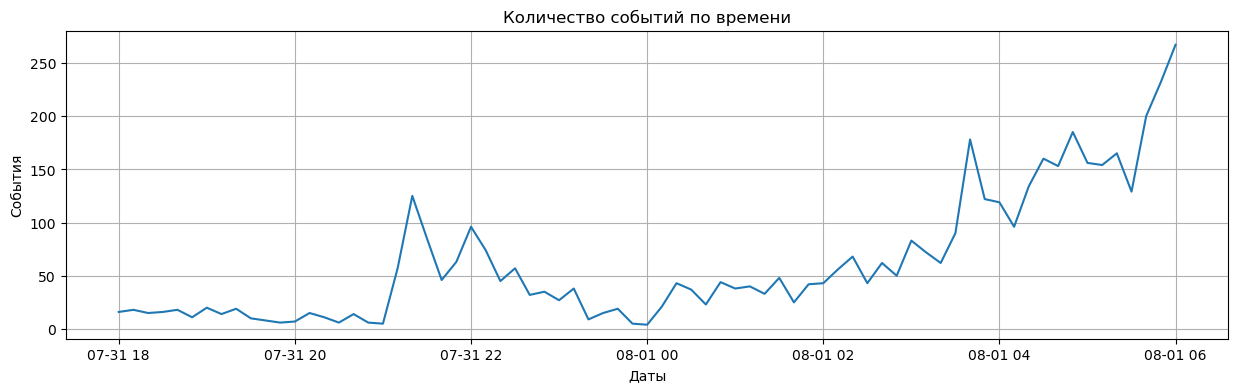

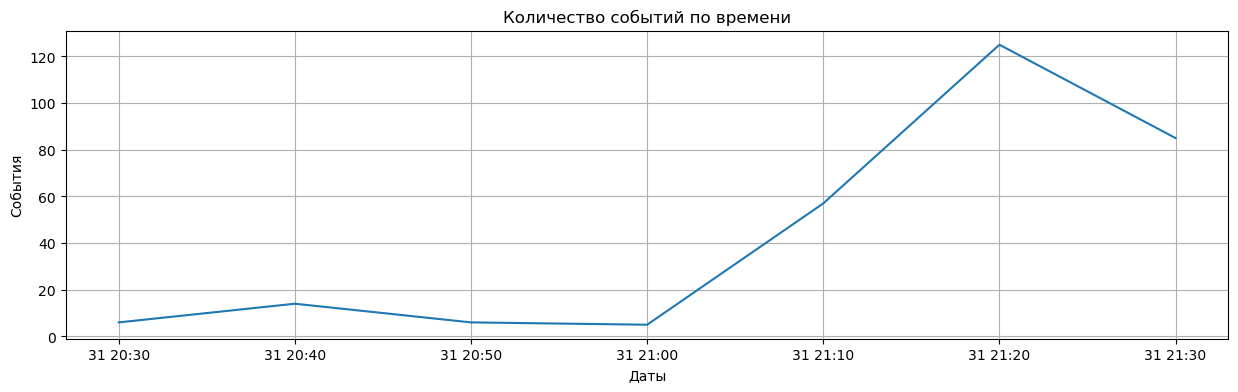

In [35]:
df['dt10m'] = df['datetime'].dt.round('10T')
dt10m_event = df.groupby('dt10m')['event'].count().reset_index()

lim = (
    ['2019-07-24','2019-08-10'],
    ['2019-07-31','2019-08-03'],
    ['2019-07-31 18:00:00', '2019-08-01 06:00:00'],
    ['2019-07-31 20:30:00','2019-07-31 21:30:00']
)

for period in lim:
    dt10m_per = dt10m_event[(dt10m_event['dt10m'] >= period[0]) & (dt10m_event['dt10m'] <= period[1])]
    
    plt.figure(figsize=(15,4))
    seaborn.lineplot(dt10m_per['dt10m'], dt10m_per['event'])
    plt.xlabel('Даты')
    plt.grid()
    plt.ylabel('События')
    plt.title('Количество событий по времени');
    plt.show();




Анализ графиков показывает наличие данных с 01.08. по 07.08.2019 года. Данные с 25.07. по 31.07. выглядят совсем не полными, они не будут использоваться при дальнейшем исследовании. Графики временного распределения активности за 31 июля и 1 августа позволяют выявить границы исследования: 21:00 31 августа. Данные за более ранний период не будут использоваться в исследовании.

Отброс неподходящих данных по времени.

In [36]:
df = df[df['datetime'] > '2019-07-31 21:00:00'].reset_index(drop=True)
df.sort_values(by='datetime')

,event,user,timestamp,group,datetime,date,dt10m
0,MainScreenAppear,7701922487875823903,2019-07-31 21:00:57,247,2019-07-31 21:00:57,2019-07-31,2019-07-31 21:00:00
1,MainScreenAppear,2539077412200498909,2019-07-31 21:01:45,247,2019-07-31 21:01:45,2019-07-31,2019-07-31 21:00:00
2,OffersScreenAppear,3286987355161301427,2019-07-31 21:02:21,248,2019-07-31 21:02:21,2019-07-31,2019-07-31 21:00:00
3,OffersScreenAppear,3187166762535343300,2019-07-31 21:02:23,247,2019-07-31 21:02:23,2019-07-31,2019-07-31 21:00:00
4,MainScreenAppear,1118952406011435924,2019-07-31 21:03:25,248,2019-07-31 21:03:25,2019-07-31,2019-07-31 21:00:00
...,...,...,...,...,...,...,...
241719,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07 21:12:25,2019-08-07,2019-08-07 21:10:00
241720,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07 21:13:59,2019-08-07,2019-08-07 21:10:00
241721,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07 21:14:43,2019-08-07,2019-08-07 21:10:00
241722,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07 21:14:58,2019-08-07,2019-08-07 21:10:00


Оценка потери при отсечении данных.

In [37]:
users_new = df['user'].nunique()
print('Количество уникальных пользователей после удаления =', users_new)
print('Разница с первоначальными данными =', users - users_new)


Количество уникальных пользователей после удаления = 7538
Разница с первоначальными данными = 13


In [38]:
print('Процент потери данных пользователей=', round(((users - users_new)/users)*100, 3))

Процент потери данных пользователей= 0.172


In [39]:
event_new =df['event'].count()
print('Количество  событий после удаления =', event_new)
print('Разница с первоначальными данными =', all_events  - event_new)

Количество  событий после удаления = 241724
Разница с первоначальными данными = 1989


In [40]:
print('Процент потери данных событий=', round(((all_events - event_new)/all_events)*100, 3))


Процент потери данных событий= 0.816


Потеря данных по пользователям составила 13 шт., 0.17% от общего количества данных. Потеря данных по событиям составила 1989 шт., 0.8% от общего количества данных. Такие потери могут считаться очень маленькими и их необходимо отбросить, чтобы получить качественное исследование.

Проверим наличие пользователей из всех трёх экспериментальных групп после удаления данных.


In [41]:
p=df.groupby('group').agg({'user': 'nunique'})
p['%']= round((p/df['user'].nunique()*100),2)
p

,user,%
group,,
246,2484,32.95
247,2517,33.39
248,2537,33.66


Изменение количества пользователей на 13 шт. практически не изменило картины разделения пользователей на группы.


В процессе изучения данных было подсчитано, что количество уникальных событий в логе равно 5, подсчитано их количество, подсчитано количество уникальных пользователей (7551 чел.), подсчитано медианное значение в 20 событий на пользователя. Определены временные границы исследования по активности пользователей. Отброшены данные, которые не удовлетворяют критериям полноты и качества исследования, оценены потери в абсолютном и относительном выражении. Можно приступать к дальнейшим исследованиям.

### Изучение воронки событий.

Анализ видов событий и их частоты.

События отсортированы по частоте.


In [42]:
events = df.groupby('event')['user'].agg(['count', 'nunique']).sort_values(by ='count', ascending= False).reset_index()
events

,event,count,nunique
0,MainScreenAppear,117889,7423
1,OffersScreenAppear,46531,4597
2,CartScreenAppear,42343,3736
3,PaymentScreenSuccessful,33951,3540
4,Tutorial,1010,843


Количество уникальных событий в логе равно 5:
1. Мainscreenappear - просмотр главного экрана.
2. OffersScreenAppear - просмотр предложений на экране.
3. CartScreenAppear - просмотр экрана корзины.
4. PaymentScreenSuccessful - просмотр экранов оплаты картой.
5. Tutorial - просмотр обучающей части.

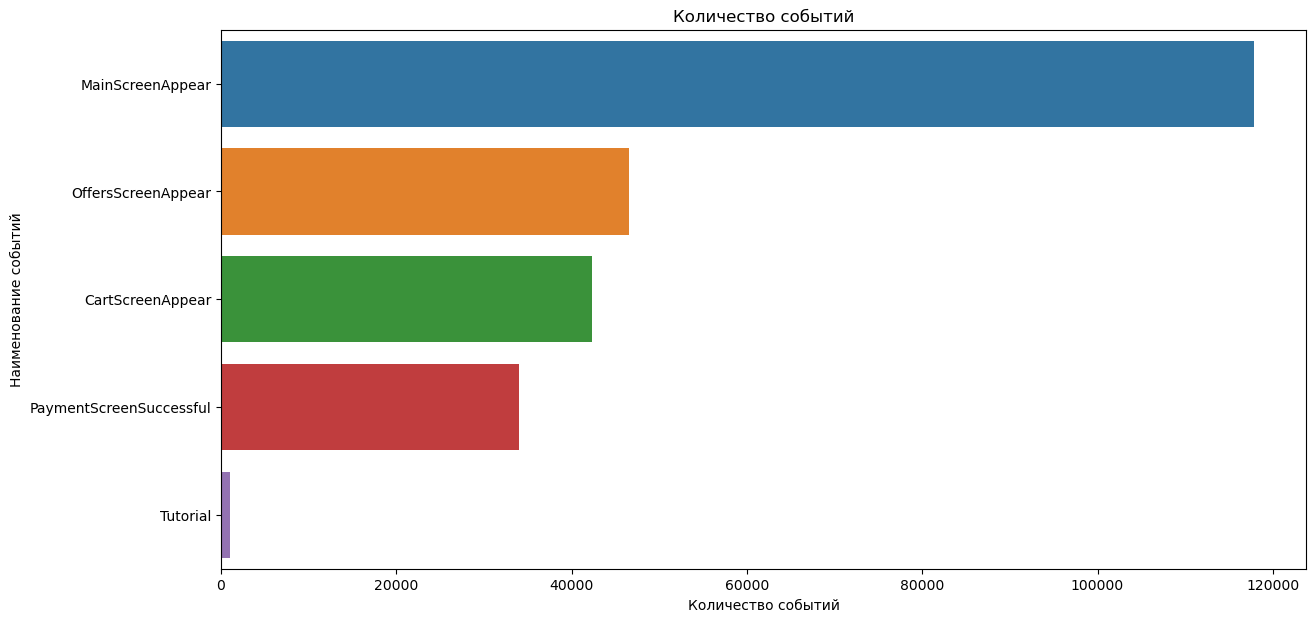

In [43]:
events.columns =['event_name', 'n_events', 'n_users']
n_users = {'all': df['user'].nunique(), 
           246: df[df['group']==246]['user'].nunique(),
           247: df[df['group']==247]['user'].nunique(),
           248: df[df['group']==248]['user'].nunique(),
           '246+247': df[(df['group']==246) | (df['group']==247)]['user'].nunique()}
plt.figure(figsize=(14, 7))

order = events.sort_values('n_events', ascending=False).reset_index(drop=True)['event_name']
ax = seaborn.barplot(y='event_name', x='n_events', order = order,  data=events)
ax.set (xlabel='Количество событий', ylabel='Наименование событий')
ax.set_title('Количество событий');

Самым популярным событием является просмотр главного экрана (почти 49%). Далее пользователи просматривают предложения на своем экране (19.2%). Третий по популярности просмотр экрана корзины (17.5%). 14% оплачивают свои покупки, просматривая страницы оплаты. Самый непопулярный раздел сайта - обучающий. В него заглядывают лишь 0.4% пользователей.

In [44]:
event_pivot=df.pivot_table(index=['event','group'], values='user', aggfunc=['count', 'nunique']).reset_index()

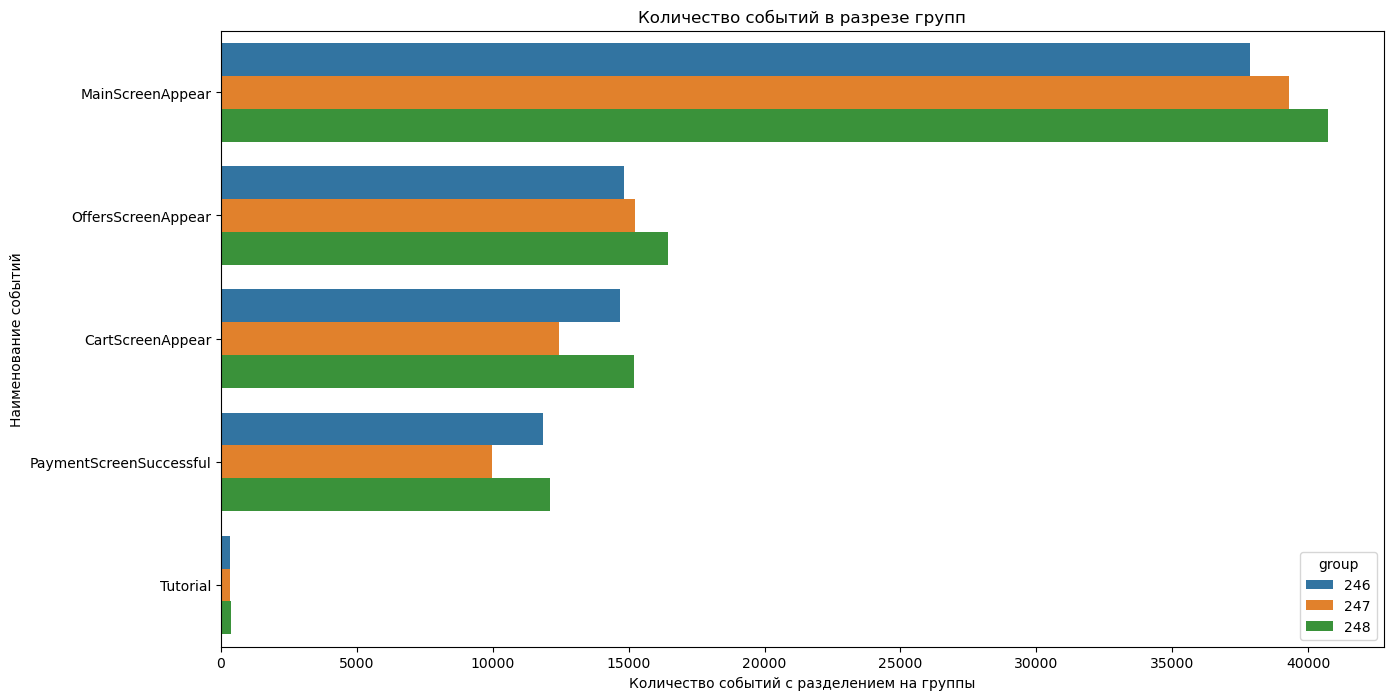

In [45]:
event_pivot.columns= ['event_name','group', 'n_events', 'n_users']

plt.figure(figsize=(15, 8))
ax = seaborn.barplot(y='event_name', x='n_events', order = order, hue='group', data=event_pivot)
ax.set_title('Количество событий в разрезе групп')
ax.set (xlabel='Количество событий с разделением на группы', ylabel='Наименование событий');

График количества событий в разрезе групп показал общую картину, схожую с графиком без разделения по группам, но детали показывают, что группа 248 лидирует по всем наименованиям событий, их количество больше. Соответственно, в ходе исследования нужно будет внимательно посмотреть на критерии статистической значимости.


Подсчет пользователей, совершивших события.

In [46]:
events_users = df.groupby('event').agg({'event':'count', 'user':'nunique'}).sort_values(by='user', ascending=False)
events_users.columns = ['n_events', 'users'] #"n_events" - кол-во событий, "users" - кол-во пользователей
events_users = events_users.reset_index()
events_users['users_1event'] = (events_users['users'] / users_new * 100).round(1) # доля совершивших событие хотя бы 1 событие
events_users

,event,n_events,users,users_1event
0,MainScreenAppear,117889,7423,98.5
1,OffersScreenAppear,46531,4597,61.0
2,CartScreenAppear,42343,3736,49.6
3,PaymentScreenSuccessful,33951,3540,47.0
4,Tutorial,1010,843,11.2


Посмотрим на данные в разрезе групп.


In [47]:
events_users_bygroup = df.groupby(['event','group']).agg({'event':'count', 'user':'nunique'})
events_users_bygroup.columns = ['n_events', 'users']
events_users_bygroup = events_users_bygroup.reset_index()

users_246 = df[df['group']==246]['user'].nunique()
users_247= df[df['group']==247]['user'].nunique()
users_248= df[df['group']==248]['user'].nunique()

def users_part_group(row):
    if row['group']==246:
        return (row['users'] / users_246 * 100)
    elif row['group']==247:
        return (row['users'] / users_247 * 100)
    elif row['group']==248:
        return (row['users'] / users_248 * 100)
    else:
        print ('Ошибка')

events_users_bygroup['users_1event'] = events_users_bygroup.apply(users_part_group, axis=1)
events_users_bygroup['users_1event'] = events_users_bygroup['users_1event'].round (2)
events_users_bygroup.sort_values(by=['group','users'], ascending=False).reset_index(drop=True)

,event,group,n_events,users,users_1event
0,MainScreenAppear,248,40740,2494,98.31
1,OffersScreenAppear,248,16465,1531,60.35
2,CartScreenAppear,248,15207,1231,48.52
3,PaymentScreenSuccessful,248,12110,1182,46.59
4,Tutorial,248,353,281,11.08
5,MainScreenAppear,247,39294,2479,98.49
6,OffersScreenAppear,247,15237,1524,60.55
7,CartScreenAppear,247,12439,1239,49.23
8,PaymentScreenSuccessful,247,9983,1158,46.01
9,Tutorial,247,340,284,11.28


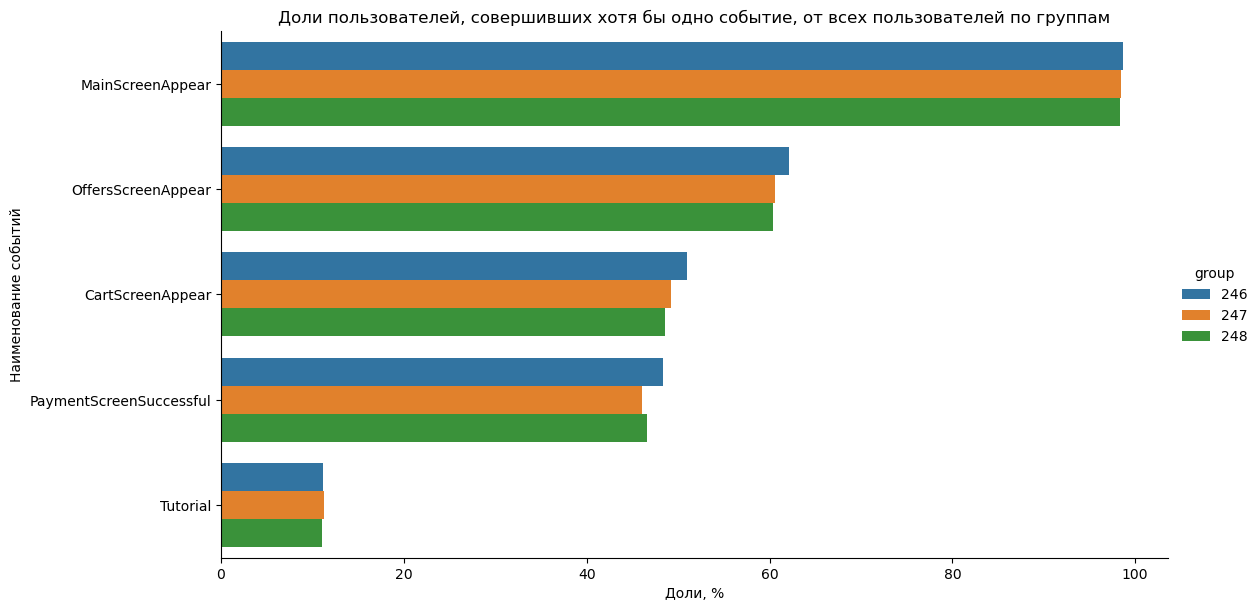

In [48]:
seaborn.catplot(y="event", x="users_1event",
                hue="group", order=order, 
                data=events_users_bygroup, kind="bar",
                height=6, aspect=2.0)
plt.ylabel('Наименование событий')
plt.xlabel('Доли, %')
plt.title('Доли пользователей, совершивших хотя бы одно событие, от всех пользователей по группам');



График разделения доли пользователей, совершивших хотя бы одно событие, разделенный по группам показывает равномерность, резкие скачки внутри групп отсутствуют.

Анализ порядка событий.

Вырисовывается следующий порядок поведения пользователей мобильного приложения при заказе продуктов питания: 

1. MainScreenAppear - Появление Главного экрана - Пользователь зашел на сайт
2. OffersScreenAppear - Появление Экрана Предложений - Пользователь просматривал страницы предложений.
3. CartScreenAppear - Появление Экрана Корзины - Пользователь добавил товар в корзину
4. PaymentScreenSuccessful - Экран Оплаты картой - Пользователи оплатили покупки из корзины.

Tutorial - Руководство пользователя - Изучение инструкции.  Изучение инструкции самое непопулярное место в мобильном приложении. Количество этих событий от общего количества событий составляет 0.4%. 


In [49]:
previous_step_users = events_users.loc[0,'users']

for i in events_users.index:
    events_users.loc[i,'relation_to_the_previous'] = (events_users.loc[i,'users'] / previous_step_users * 100).round(1)
    previous_step_users= events_users.loc[i,'users']
events_users1=events_users  

events_users1[['event',  'users', 'relation_to_the_previous']]


,event,users,relation_to_the_previous
0,MainScreenAppear,7423,100.0
1,OffersScreenAppear,4597,61.9
2,CartScreenAppear,3736,81.3
3,PaymentScreenSuccessful,3540,94.8
4,Tutorial,843,23.8


Количество пользователей, которые перешли с главного экрана на просмотр предложений продуктов питания уменьшился на 38.1% (количество перешедших составило 61.9%). Далее, из просмотревших товары пользователей, 18.7 % не положили товар в корзину (81.3% воспользовались корзиной и положили в нее будущие покупки). Из положивших товары в корзину не оплачивают свои покупки только 5.2% пользователей, а остальные 94.8% пользователей, которые положили покупки в корзину, успешно оплачивают свои заказы. Больше всего пользователей теряется на этапе просмотра главного экрана мобильного приложения. Большой процент пользователей не захотел продолжить использоватеь мобильное приложение и не просмотрел предложения товаров стартапа. 

Теперь посмотрим на воронку в разрезе групп пользователей.

In [50]:
events_users_bygroup = df.groupby(['event','group']).agg({'event':'count', 'user':'nunique'})
events_users_bygroup.columns = ['n_events', 'users']
events_users_bygroup = events_users_bygroup.reset_index()
events_users_bygroup1=events_users_bygroup.sort_values(by=['group','users'], ascending=False).reset_index(drop=True)
        
previous_step_events_group_bygroup = -1
for i in events_users_bygroup1.index: 
    
    if previous_step_events_group_bygroup == events_users_bygroup1.loc[i,'group']:
        events_users_bygroup1.loc[i,'relation_to_the_previous'] = (events_users_bygroup1.loc[i,'users'] / previous_step_events_users_bygroup * 100).round(1)
        
    else:
        events_users_bygroup1.loc[i,'relation_to_the_previous'] = 100
        previous_step_events_group_bygroup  = events_users_bygroup1.loc[i,'group']
    previous_step_events_users_bygroup = events_users_bygroup1.loc[i,'users']  
              
events_users_bygroup1.sort_values(by=['relation_to_the_previous'], ascending=False).reset_index(drop=True)

events_users_bygroup1
events_users_bygroup1[['event', 'group', 'users', 'relation_to_the_previous']]



,event,group,users,relation_to_the_previous
0,MainScreenAppear,248,2494,100.0
1,OffersScreenAppear,248,1531,61.4
2,CartScreenAppear,248,1231,80.4
3,PaymentScreenSuccessful,248,1182,96.0
4,Tutorial,248,281,23.8
5,MainScreenAppear,247,2479,100.0
6,OffersScreenAppear,247,1524,61.5
7,CartScreenAppear,247,1239,81.3
8,PaymentScreenSuccessful,247,1158,93.5
9,Tutorial,247,284,24.5


В таблице воронки в разрезе групп пользователей также виден отток пользователей на этапе просмотра главного экрана и высокий процент оплаты покупок пользователями, после того, как они положили товары себе в корзину. 

Подсчет доли пользователей, проходящих на следующий шаг воронки без учета последовательности событий.

   Анализ таблицы перехода пользователей по шагам пользовательского пути показывает значительные потери на этапе перехода от главного экрана к процессу выбора покупок. 
   Данные  почти не отличаются в зависимости от номера группы. На первом этапе воронки при просмотре главного экрана ушли 37.1% пользователей из группы 246, 38.5% из группы 247 и 38.6% из группы 248. Далее на этапе просмотра предложений и до этапа занесения товара в корзину потеряли интерес к мобильному приложению 17.9 % пользователей групп 246 и 18.7% группы 247. Далее до самого важного этапа оплаты  товаров из корзины не пришли 5.2% пользователей группы 246, 6.2% группы 247 и 6% группы 248. 
    Получается следующая картина. Самый большой отток пользователей мобильного приложения происходит именно перед моментом просмотра предложения товара в мобильном приложении. Возможно нужно обратить внимание на интерфейс приложения, возможно людям неудобно находить меню или переходить с главного экрана в каталог товаров, а, возможно, интерфейс мобильного приложения не современный и не привлекает пользователей.

На этапе изучения воронки событий были детально разобраны события, которые случаются с пользователем, при заказе продуктов питания в мобильном приложении. Проанализирована частота событий в общем и в разрезе исследуемых групп.  Изучен отток пользователей на каждом этапе воронки и даны рекомендации отделу маркетинга.

### Изучение результата эксперимента.

Подсчет пользователей в каждой экспериментальной группе.

In [51]:
p=df.groupby('group').agg({'user': 'nunique'})
p['%']= round((p/df['user'].nunique()*100),2)
p

,user,%
group,,
246,2484,32.95
247,2517,33.39
248,2537,33.66


Немного теоретических данных: перед проведением A/B-теста, необходимо убедится, что: 

    на результаты не влияют аномалии и выбросы в генеральной совокупности;
    инструмент «деления» трафика работает безошибочно;
    данные отправляются в системы аналитики корректно.

Для этого проводят A/A-тест. Он похож на A/B-тест, только группам показывают не разные, а одинаковые версии страниц. Если трафик и инструмент проведения A/A-теста не подвели, различий в показателях не будет. Ещё А/А-тест помогает определить длительность теста и методику анализа данных. 
Критерии успешного A/A-теста: 

    Количество пользователей в различных группах различается не более, чем на 1%;
    Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
    Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
    Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

Степень различия ключевых метрик по группам зависит от необходимой чувствительности эксперимента. Скажем, если вы хотите определить результаты теста, в котором ожидаете не менее 30% прироста, то 10% погрешности измерений вас устроят. Однако такое бывает редко: изменение показателей на 30% обычно заметно и без A/B-теста. Его применяют там, где степень различия между группами не больше 10%, или же подвержены колебаниям. В таких случаях точность A/A-теста в 1% — распространённый критерий.

Исходя из теоретических данных, применим статистические критерии для поиска разницы между контрольными группами 246 и 247 в разрезе событий с уровнем статистической значимости 0.01. Также учитывая множественность тестирования будет применена поправка Шидака.

Подготовим таблицу с количеством пользователей, совершивших каждое из событий, по которым будет идти проверка.

In [52]:
order = (events[events['event_name'] != 'Tutorial'].sort_values('n_events', ascending=False)['event_name'].reset_index(drop=True))

groups = [246, 247, 248]
test_data = {}
test_data['event_name'] = order
for group in groups:
    test_data[group] =[]
    for event in order:
        test_data[group].append(df[(df['group'] == group) & (df['event'] == event)]['user'].nunique())

test_data = pd.DataFrame(test_data)
test_data['246_247'] = test_data[246] + test_data[247]
test_data['all_groups'] = test_data[246] + test_data[247] + test_data[248]
test_data['246_all'] =   df[df['group']==246]['user'].nunique()
test_data['247_all'] =   df[df['group']==247]['user'].nunique()
test_data['248_all'] =   df[df['group']==248]['user'].nunique()
test_data['246+247_all'] = df[(df['group']==246) | (df['group']==247)]['user'].nunique()
test_data

,event_name,246,247,248,246_247,all_groups,246_all,247_all,248_all,246+247_all
0,MainScreenAppear,2450,2479,2494,4929,7423,2484,2517,2537,5001
1,OffersScreenAppear,1542,1524,1531,3066,4597,2484,2517,2537,5001
2,CartScreenAppear,1266,1239,1231,2505,3736,2484,2517,2537,5001
3,PaymentScreenSuccessful,1200,1158,1182,2358,3540,2484,2517,2537,5001


Подготовим функцию для математических вычислений для статистического теста, возвращающую расчетное значение в стандартных отклонениях нормального распределения.

In [53]:
def z_test (number_1, number_2, all_number_1, all_number_2):
        # пропорция успехов в первой группе:
        p1 = number_1 / all_number_1
        # пропорция успехов во второй группе:
        p2 = number_2 / all_number_2
        # пропорция успехов в комбинированном датасете:
        p_comb = (number_1+number_2)/(all_number_1 +all_number_2)
        # разница пропорций
        diff = p1 - p2
        #расчет  статистики в стандартных отклонениях стандартного нормального распределения
        z_value = diff/mth.sqrt(p_comb * (1 - p_comb)*(1/all_number_1 +1/all_number_2))
    
        return  z_value

Сделаем расчет поправки для множественных тестов.

Несколько сравнений, проводимых на одних и тех же данных — это множественный тест. Его важная особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. 

    Метод Шидака
Скорректированное значение требуемого уровня значимости рассчитывается по  формуле 1 - (1 - a)^(1/m), где а- альфа, а m- количество сравнений. В исследвании нам предстоит сделать 16 статистических тестов, 4 из них для определения равенства контрольных групп 246 и 247 с уровнем значимости 0.01, а остальные сревнения контрольных групп с экспериментальной группой 248 и сравнение объединенных контрольных групп с экспериментальной с уровнем значимости 0.05.
При ɑ = 0.01, m = 4 при 4 сравнениях 1 - (1 - 0.05)**(1/4) =0.002509430066318874

А при ɑ = 0.05, m = 12 при 12 сравнениях: 1 - (1 - 0.05)**(1/12) = 0.004265318777560645

Сформулируем гипотезы:

Нулевая гипотеза: различий между контрольными группами 246 и 247 в разрезе событий нет

Альтернативная гипотеза: различия между контрольными группами 246 и 247 в разрезе событий есть

Вызовем 4 цикла, в которых вызывается функция для подстчета математических данных, для каждой пары исследуемых групп т.е. всего 4 цикла.

In [54]:
alpha =0.01
m = 4
alpha_Shidak=1 - (1 - alpha)**(1/m)
distr = stats.norm(0, 1) 
for i in test_data.index:
    number_1= test_data.loc[i, 246]
    number_2= test_data.loc[i, 247]
    all_number_1= test_data.loc[i, '246_all']
    all_number_2= test_data.loc[i, '247_all']
    z_value=z_test (number_1, number_2, all_number_1, all_number_2)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('{} p-значение: {}'.format(test_data['event_name'][i], p_value))
    if (p_value < alpha_Shidak):
        print("Отвергаем нулевую гипотезу: между группами 246 и 247 есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 247 разными")

MainScreenAppear p-значение: 0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 247 разными
OffersScreenAppear p-значение: 0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 247 разными
CartScreenAppear p-значение: 0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 247 разными
PaymentScreenSuccessful p-значение: 0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 247 разными


Теперь сравним результаты с каждой из контрольных групп в отдельности по каждому событию с группой 248.
Группы 246 и 248.

Сформулируем гипотезы:

Нулевая гипотеза: различий между контрольной группой 246 и экспериментальной 248 группой в разрезе событий нет

Альтернативная гипотеза: различия между контрольной группой 246 и экспериментальной 248 группой в разрезе событий есть

In [55]:
alpha =0.05
m = 12
alpha_Shidak=1 - (1 - alpha)**(1/m) 

distr = stats.norm(0, 1) 
for i in test_data.index:
    number_1= test_data.loc[i, 246]
    number_2= test_data.loc[i, 248]
    all_number_1= test_data.loc[i, '246_all']
    all_number_2= test_data.loc[i, '248_all']
    z_value=z_test (number_1, number_2, all_number_1, all_number_2)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
   
    print('{} p-значение: {}'.format(test_data['event_name'][i], p_value))
    if (p_value < alpha_Shidak):
        print("Отвергаем нулевую гипотезу: между группами 246 и 248 есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 248 разными")

MainScreenAppear p-значение: 0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 248 разными
OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 248 разными
CartScreenAppear p-значение: 0.08328412977507749
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 248 разными
PaymentScreenSuccessful p-значение: 0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246 и 248 разными


Группы 247 и 248.

Сформулируем гипотезы:

Нулевая гипотеза: различий между контрольной группой 247 и экспериментальной 248 группой в разрезе событий нет

Альтернативная гипотеза: различия между контрольной группой 247 и экспериментальной 248 группой в разрезе событий есть

In [56]:
alpha =0.05
m = 12
alpha_Shidak=1 - (1 - alpha)**(1/m) 
distr = stats.norm(0, 1) 
for i in test_data.index:
    number_1= test_data.loc[i, 247]
    number_2= test_data.loc[i, 248]
    all_number_1= test_data.loc[i, '247_all']
    all_number_2= test_data.loc[i, '248_all']
    z_value=z_test (number_1, number_2, all_number_1, all_number_2)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('{} p-значение: {}'.format(test_data['event_name'][i], p_value))
    if (p_value < alpha_Shidak):
        print("Отвергаем нулевую гипотезу: между группами 247 и 248 есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 247 и 248 разными")

MainScreenAppear p-значение: 0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 247 и 248 разными
OffersScreenAppear p-значение: 0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 247 и 248 разными
CartScreenAppear p-значение: 0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 247 и 248 разными
PaymentScreenSuccessful p-значение: 0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 247 и 248 разными


Теперь сравним контрольные 246 и 247, объединенные в одну группу, с экспериментальной 248-ой: Сформулируем гипотезы:

Нулевая гипотеза: различий между контрольными группами 246+247 и 248 в разрезе событий нет

Альтернативная гипотеза: различия между контрольными группами 246+247 и 248 в разрезе событий есть


In [57]:
alpha =0.05
m = 12
alpha_Shidak=1 - (1 - alpha)**(1/m) 
distr = stats.norm(0, 1) 
for i in test_data.index:
    number_1= test_data.loc[i, '246_247']
    number_2= test_data.loc[i, 248]
    all_number_1= test_data.loc[i, '246+247_all']
    all_number_2= test_data.loc[i, '248_all']
    z_value=z_test (number_1, number_2, all_number_1, all_number_2)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('{} p-значение: {}'.format(test_data['event_name'][i], p_value))
    if (p_value < alpha_Shidak):
        print("Отвергаем нулевую гипотезу: между группами 246+247 и 248 есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246+247 и 248 разными")

MainScreenAppear p-значение: 0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246+247 и 248 разными
OffersScreenAppear p-значение: 0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246+247 и 248 разными
CartScreenAppear p-значение: 0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246+247 и 248 разными
PaymentScreenSuccessful p-значение: 0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы 246+247 и 248 разными


Статистические критерии показали отсутствие оснований считать контрольную объединенную группу 246 + 247 и экспериментальную 248 в разрезе событий разными.

Все проведенные статистические тесты показали отсутствие разницы между группами. Всего проведено 16 тестов между контрольными и экспериментальной группами. Уровень статистической значимости для теста между контрольными группами 246 и 247 взят 0.01. (Проведено 4 теста). Для исследования остальных групп принят уровень статистической значимости 0.05 (Проведено 12 тестов). Уровень статистической значимости использован с попрвкой Шидака.

### Выводы.

Стартапу, продающему через мобильное приложение продукты питания, необходимо провести анализ поведения пользователей в мобильном приложении для определения целесообразности перехода мобильного приложения на новый шрифт. В исследовании участвуют 3 группы (контрольная 246, 247 и экспериментальная 248 (которой и показывается новый шрифт).
   
   Для проведения анализа предоставлены данные в размере 244 126  строк, в которых в процессе предобработки данных были обнаружены и исправлены: несоответствия формата даты, исследованы и удалены дубликаты ( 413 строк - 0.17 % от имеющихся данных), произведен подсчет и сравнение количества уникальных пользователей, разделенных на группы. Выяснено, что имеется лишь очень незначительное неравенство количества пользователей в трех группах. Дальнейшая проверка равенства групп проводилась с использованием статистических критериев.
   
   На этапе изучения данных выявлены 5 событий в логе: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful и Tutorial. Самое популярное из них просмотр главного экрана (MainScreenAppear).  Среднее количество событий на пользователя 32.28, однако в ходе исследования обнаружены выбросы, слишком большие значения, которые повлияли на среднее арифметическое значение. Принято решение посчитать медианное количество событий на пользователя и оно равно 20 событиям на пользователя.
    
   Далее произведен анализ временного периода предоставленных данных. Данные собраны с 25.07. по 07.08.2019 года. Проведенный анализ показал неполноту данных и невозможность их использования за первые дни сбора данных. Принято решение об участии в исследовании данных с 21:00 31.07.2019 года. Потеря данных по пользователям составила 13 шт., 0.17% от общего количества данных. Потеря данных по событиям составила 1989 шт., 0.8% от общего количества данных. Такие потери могут считаться очень маленькими и их необходимо отбросить, чтобы получить качественное исследование.
    
   Изучение воронки событий показала, что самое непопулярное место в мобильном приложении это руководство пользователя. Самым популярным событием является просмотр главного экрана. Далее пользователи просматривают предложения на своем экране. Третий по популярности просмотр экрана корзины. Далее пользователи оплачивают свои покупки, просматривая страницы оплаты. Самый непопулярный раздел сайта - обучающий. Количество пользователей, которые перешли с главного экрана на просмотр предложений продуктов питания уменьшился на 38.1% (количество перешедших составило 61.9%). Далее, из просмотревших товары пользователей, 18.7 % не положили товар в корзину (81.3% воспользовались корзиной и положили в нее будущие покупки). Из положивших товары в корзину не оплачивают свои покупки только 5.2% пользователей, а остальные 94.8% пользователей, которые положили покупки в корзину, успешно оплачивают свои заказы. 
   
   Больше всего пользователей теряется на этапе просмотра главного экрана мобильного приложения. Большой процент пользователей не захотел продолжить использоватеь мобильное приложение и не просмотрел предложения товаров стартапа. Возможные причины нежелания людей просматривать товары: не привлекательный внешний вид мобильного приложения, запутанный интерфейс. Нужно отбратить внимание отдела маркетинга на большой отток пользователей мобильного приложения перед просмотром товаров.
   
   Далее применялись статистические критерии для поиска разницы в поведении контрольных 246,247 и экспериментальной 248 группы. Для начала проверялось отсутствие статистически значимой разницы между контрольными группами 246 и 247. Уровень статистической значимости для данных тестов использовался на уровне 1%, поскольку определение оснований наличия или отсутствия равенства между контрольными группами требует большей точности, чем стандартные критерии для А/В тестирования в размере 5%. В исследовании был применен метод Шидака. Скорректированное значение расчитывалось при ɑ = 0.01 на 4 теста  (в расчетах m = 4) и ɑ = 0.05  при 12 сравнениях (m = 12 в 12 расчетах). 
     
   Все проведенные тесты показали отсутствие разницы между поведением пользователей по событиям в разрезе групп. Соответственно, тестирование показало отсутствие разницы для пользователя какой именно шрифт (тот, к которому привыкли пользователи или новый шрифт, который показывался 248 группе пользователей) будет использован в работе мобильного приложения.
   
   Соответственно, по результатам тестирования новый шрифт можно не внедрять, а потратить ресурсы стартапа на проведение изучения причин оттока пользователей мобильного приложения после просмотра главного экрана, на повышение привлекательности мобильного приложежния и на улучшение интерфеса, неудобства которого, могут быть причиной нежелания пользователей просматривать товары мобильного приложения.